In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('data/Data_Train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78458 entries, 0 to 78457
Data columns (total 11 columns):
Unique_ID     78458 non-null int64
Name          78458 non-null object
Genre         78458 non-null object
Country       78458 non-null object
Song_Name     78457 non-null object
Timestamp     78458 non-null object
Views         78458 non-null int64
Comments      78458 non-null int64
Likes         78458 non-null object
Popularity    78458 non-null object
Followers     78458 non-null int64
dtypes: int64(4), object(7)
memory usage: 6.6+ MB


In [3]:
df['Name'] = pd.factorize(df.Name)[0]
df['Genre'] = pd.factorize(df.Genre)[0]

In [4]:
df = df[['Name', 'Genre', 'Timestamp', 'Comments', 'Likes', 'Popularity', 'Followers', 'Views']]

In [5]:
def cleaner(x):
    if ',' in x:
        x = x.replace(',', '')
    elif 'M' in x:
        x = float(x.replace('M', ''))
        x = x*10**6
    elif 'K' in x:
        x = float(x.replace('K', ''))
        x = x*10**3
    return float(x)

In [6]:
df.Likes = df.Likes.apply(lambda x: cleaner(x))
df.Popularity = df.Popularity.apply(lambda x: cleaner(x))

In [7]:
#df.columns = df.columns.str.lower()
df.columns = map(str.lower, df.columns)

In [8]:
df['timestamp'] = pd.to_datetime(df.timestamp)

In [9]:
from datetime import datetime
df['year'] = df.timestamp.dt.year
df['month'] = df.timestamp.dt.month
df['day'] = df.timestamp.dt.day
df['day_of_year'] = df.timestamp.dt.dayofyear
df['day_of_week'] = df.timestamp.dt.dayofweek
df['is_weekend'] = (df.timestamp.dt.weekday>=5).astype(int)
df['week'] = df.timestamp.dt.week
df['days_since_release'] = (datetime.now() - df.timestamp).dt.days
df['engagement'] = df.likes + df.comments
df['engagement_ratio'] = df['engagement'] / df['followers']

In [10]:
df.columns

Index(['name', 'genre', 'timestamp', 'comments', 'likes', 'popularity',
       'followers', 'views', 'year', 'month', 'day', 'day_of_year',
       'day_of_week', 'is_weekend', 'week', 'days_since_release', 'engagement',
       'engagement_ratio'],
      dtype='object')

In [30]:
X = df[['name', 'genre', 'comments', 'likes', 'popularity',
       'followers', 'year', 'month', 'day', 'day_of_year',
       'day_of_week', 'is_weekend', 'week', 'days_since_release',
       'engagement']]
y = df['views']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)

In [12]:
X_train.head()

,name,genre,comments,likes,popularity,followers,year,month,day,day_of_year,day_of_week,is_weekend,week,days_since_release,engagement,engagement_ratio
71785,89,5,4,59.0,12.0,165268,2014,3,14,73,4,0,11,2162,63.0,0.000381
42292,54,4,96,143.0,91.0,6084,2018,7,26,207,3,0,30,568,239.0,0.039283
55016,412,3,0,6.0,2.0,342,2019,1,23,23,2,0,4,386,6.0,0.017544
50270,75,0,2,85.0,29.0,29446,2014,9,10,253,2,0,37,1982,87.0,0.002955
54582,324,3,435,2839.0,684.0,106971,2018,2,5,36,0,0,6,738,3274.0,0.030606


In [13]:
clf = LinearRegression(normalize=True)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_val)

print(np.sqrt(mean_squared_error(y_val, y_pred)))
print(mean_squared_error(y_val, y_pred))

#without engagement ratio
#789180.988643476
#622806632836.2943

#with engagement ratio
#601527.5878659646
#361835438963.84576

721911.6698457112
521156459059.4232


In [14]:
rf = RandomForestRegressor()

rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)

print(np.sqrt(mean_squared_error(y_val, y_pred)))
print(mean_squared_error(y_val, y_pred))

#without engagement ratio
#767096.827670948
#588437543022.8322

#leaderboardscore : 827580.07742

#with engagement ratio
#496282.4861702416
#246296306079.31604

711707.5566895821
506527646249.05475


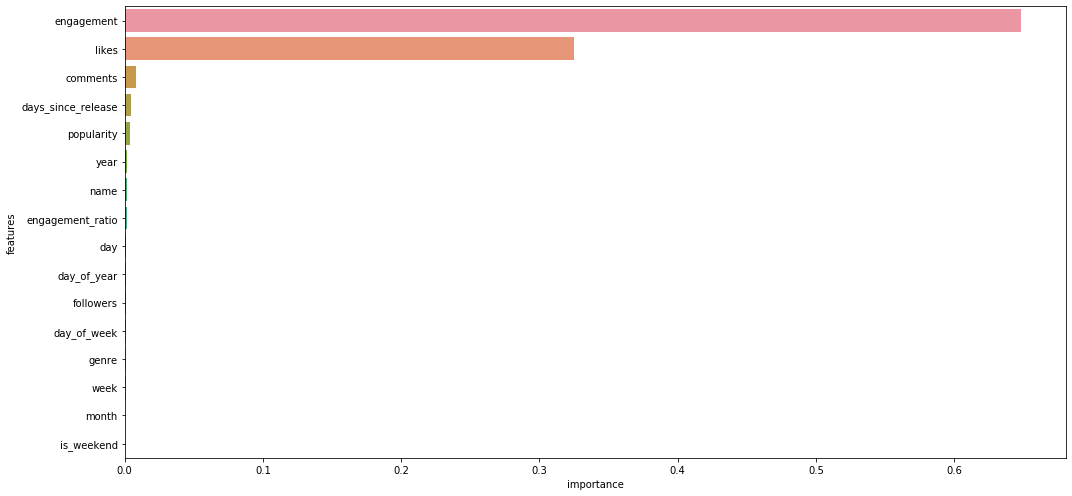

In [15]:
import seaborn as sns
feature_importance = pd.DataFrame(sorted(zip(X_train.columns, rf.feature_importances_), reverse=True), columns=['features', 'importance'])
plt.figure(figsize=(15,7))
sns.barplot(y='features', x='importance', data=feature_importance.sort_values(by='importance', ascending=False))
plt.tight_layout()

In [20]:
import xgboost as xgb

xgb = xgb.XGBRegressor()

xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_val)

print(np.sqrt(mean_squared_error(y_val, y_pred)))
print(mean_squared_error(y_val, y_pred))

#leaderboard score : 751217.21271

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[05:44:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
764246.8194616248
584073201057.2094


In [ ]:
feature_importance = pd.DataFrame(sorted(zip(xgb1.feature_importances_, X_train.columns), reverse=True), 
                                  columns=['importance', 'features'])

sns.barplot(x='importance', y='features', data=feature_importance)

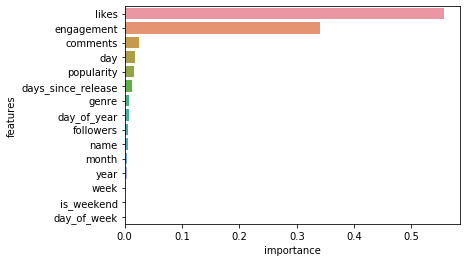

In [28]:
feature_importance = pd.DataFrame(sorted(zip(xgb.feature_importances_, X_train.columns), reverse=True), 
                                  columns=['importance', 'features'])

sns.barplot(x='importance', y='features', data=feature_importance)

In [37]:
df_test = pd.read_csv('data/Data_Test.csv')

df_test['Name'] = pd.factorize(df_test.Name)[0]
df_test['Genre'] = pd.factorize(df_test.Genre)[0]

#df_test = df_test[['Name', 'Genre', 'Timestamp', 'Comments', 'Likes', 'Popularity', 'Followers', 'Views']]

def cleaner(x):
    if ',' in x:
        x = x.replace(',', '')
    elif 'M' in x:
        x = float(x.replace('M', ''))
        x = x*10**6
    elif 'K' in x:
        x = float(x.replace('K', ''))
        x = x*10**3
    return float(x)

df_test.Likes = df_test.Likes.apply(lambda x: cleaner(x))
df_test.Popularity = df_test.Popularity.apply(lambda x: cleaner(x))

#df_test.columns = df_test.columns.str.lower()
df_test.columns = map(str.lower, df_test.columns)

df_test['timestamp'] = pd.to_datetime(df_test.timestamp)

from datetime import datetime
df_test['year'] = df_test.timestamp.dt.year
df_test['month'] = df_test.timestamp.dt.month
df_test['day'] = df_test.timestamp.dt.day
df_test['day_of_year'] = df_test.timestamp.dt.dayofyear
df_test['day_of_week'] = df_test.timestamp.dt.dayofweek
df_test['is_weekend'] = (df_test.timestamp.dt.weekday>=5).astype(int)
df_test['week'] = df_test.timestamp.dt.week
df_test['days_since_release'] = (datetime.now() - df_test.timestamp).dt.days
df_test['engagement'] = df_test.likes + df_test.comments
df_test['engagement_ratio'] = df['engagement'] / df['followers']

df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19615 entries, 0 to 19614
Data columns (total 20 columns):
unique_id             19615 non-null int64
name                  19615 non-null int64
genre                 19615 non-null int64
country               19615 non-null object
song_name             19615 non-null object
timestamp             19615 non-null datetime64[ns]
comments              19615 non-null int64
likes                 19615 non-null float64
popularity            19615 non-null float64
followers             19615 non-null int64
year                  19615 non-null int64
month                 19615 non-null int64
day                   19615 non-null int64
day_of_year           19615 non-null int64
day_of_week           19615 non-null int64
is_weekend            19615 non-null int32
week                  19615 non-null int64
days_since_release    19615 non-null int64
engagement            19615 non-null float64
engagement_ratio      19615 non-null float64
dtypes: date

In [76]:
df_pred = df_test[['name', 'genre', 'comments', 'likes', 'popularity', 'followers', 'year', 'month', 'day', 
                   'day_of_year', 'day_of_week', 'is_weekend', 'week', 'days_since_release', 'engagement']]
y_pred = xgb1.predict(df_pred)

In [77]:
sub = pd.DataFrame({'Unique_ID':df_test['unique_id'], 'Views':y_pred})
sub.head()

,Unique_ID,Views
0,562546,312406.937500
1,907584,35879.851562
2,213013,18946.710938
3,340312,22689.210938
4,41854,11510.787109


In [78]:
sub.to_excel('XGB1.xlsx')

In [ ]:
#stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, xgboost, lightgbm),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)